# Scenario Dashboard

Examinez l'impact des scénarios prospectifs sur les probabilités de cycle (Markov/Kalman/blend), comparez-les au cas de base et visualisez la trajectoire des régimes. Ce notebook peut soit charger un scénario pré-calculé, soit générer un choc sur mesure en saisissant vos propres overrides.


In [1]:
import sys
from pathlib import Path

# Racine du projet (chemin absolu explicite pour fiabiliser les entrées/sorties)
PROJECT_ROOT = Path(r"C:\Users\amoni\OneDrive\Documents\COURS\M2 Quant\macro quant\Projet")

SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from recession_indicator import compute_cycle_probabilities, load_panel
from run_scenario import (
    apply_overrides,
    ensure_output_horizon,
    extend_panel_for_future,
    infer_frequency,
    load_baseline_probs,
)

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
SCENARIO_DIR = DATA_PROCESSED / "scenarios"
BASELINE_CSV = DATA_PROCESSED / "recession_prob.csv"

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)


In [2]:
# Paramètres utilisateur – à ajuster avant d'exécuter le reste du notebook
USE_CUSTOM_OVERRIDES = True  # True = utiliser USER_OVERRIDES ci-dessous, False = charger un CSV existant
SCENARIO_NAME = "us_hard_landing"  # Nom du fichier CSV: data/processed/scenarios/scenario_<nom>.csv
SCENARIO_LABEL = "US Hard Landing"  # Légende utilisée dans les graphiques et tableaux

# Exemple d'overrides personnalisés. Modifiez, ajoutez ou supprimez des blocs selon vos besoins.
USER_OVERRIDES = [
    {
        "column": "us_gdp_qoq",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "value": -10,
    },
    {
        "column": "us_ism_manufacturing",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "value": 34,
    },
    {
        "column": "us_michigan_sentiment",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "value": 40,
    },
    {
        "column": "us_initial_claims",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "delta_pct": 1.5,
    },
    {
        "column": "us_nfp_change",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "value": -500,
    },
    {
        "column": "us_cpi_mom",
        "start": "2026-01-01",
        "end": "2026-12-31",
        "value": -0.4,
    },
]


In [3]:
def load_baseline_df() -> pd.DataFrame:
    """Charge le fichier baseline (recession_prob.csv)."""
    if not BASELINE_CSV.exists():
        raise FileNotFoundError(
            "Fichier baseline manquant. Lancez `python src/recession_indicator.py` pour le régénérer."
        )
    return pd.read_csv(BASELINE_CSV, index_col=0, parse_dates=True)


def load_scenario_csv(name: str) -> pd.DataFrame:
    path = SCENARIO_DIR / f"scenario_{name}.csv"
    if not path.exists():
        raise FileNotFoundError(f"Aucun scénario trouvé à {path}")
    return pd.read_csv(path, index_col=0, parse_dates=True)


def build_custom_scenario(overrides: list[dict]) -> pd.DataFrame:
    """Recalcule un scénario ad hoc en appliquant les overrides fournis."""
    if not overrides:
        return load_baseline_df()

    panel = load_panel()
    baseline = load_baseline_probs(panel)
    last_hist_obs = panel.index.max()
    hist_cutoff = baseline.index.max()

    extended = extend_panel_for_future(panel, overrides)
    adjusted = apply_overrides(extended, overrides, last_hist_obs)
    probs = compute_cycle_probabilities(adjusted)

    future = probs.loc[probs.index > hist_cutoff]
    combined = pd.concat([baseline, future], axis=0)
    combined = combined[~combined.index.duplicated(keep="last")].sort_index()

    hist_mask = combined.index <= hist_cutoff
    if hist_mask.any():
        baseline_aligned = baseline.reindex(combined.index).ffill()
        combined.loc[hist_mask] = baseline_aligned.loc[hist_mask]

    freq = infer_frequency(combined.index)
    combined = ensure_output_horizon(combined, overrides, freq)
    return combined


def format_last_observation(df: pd.DataFrame) -> pd.Series:
    row = df.iloc[-1].copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        row[col] = pd.to_numeric(row[col], errors="coerce").round(3)
    return row


In [4]:
baseline_df = load_baseline_df()

if USE_CUSTOM_OVERRIDES:
    scenario_df = build_custom_scenario(USER_OVERRIDES)
    scenario_label = SCENARIO_LABEL or "Scénario personnalisé"
    scenario_origin = "Overrides saisis dans le notebook"
else:
    scenario_df = load_scenario_csv(SCENARIO_NAME)
    scenario_label = SCENARIO_LABEL or SCENARIO_NAME
    scenario_origin = f"CSV existant: scenario_{SCENARIO_NAME}.csv"

cutoff = baseline_df.index.max()
max_hist_gap = (
    baseline_df.loc[:cutoff, "blended_prob"]
    - scenario_df.loc[:cutoff, "blended_prob"]
).abs().max()

print(f"Baseline disponible jusqu'au {cutoff.date()} – écart hist. max (blend): {max_hist_gap:.4g}")
print(f"Source scénario : {scenario_origin}")
print(f"Période disponible : {scenario_df.index.min().date()} -> {scenario_df.index.max().date()}")
print("Dernière observation scénario :")
display(format_last_observation(scenario_df).to_frame(name=scenario_label))


Baseline disponible jusqu'au 2025-11-30 – écart hist. max (blend): 0
Source scénario : Overrides saisis dans le notebook
Période disponible : 1947-09-30 -> 2026-12-31
Dernière observation scénario :


,US Hard Landing
recession_prob,1.0
reprise_prob,0.0
boom_prob,0.0
ralentissement_prob,0.0
cycle_phase,recession_prob
markov_prob,1.0
kalman_prob,0.964
blended_prob,1.0


In [5]:
display(scenario_df.head())
display(scenario_df.tail())

describe_df = scenario_df.describe().T
counts = scenario_df.notna().sum().rename("obs_count")
first_last = pd.DataFrame(
    {
        "first_obs": scenario_df.apply(lambda s: s.dropna().index.min()),
        "last_obs": scenario_df.apply(lambda s: s.dropna().index.max()),
    }
)
coverage = describe_df.join(counts).join(first_last)
display(coverage)


,recession_prob,reprise_prob,boom_prob,ralentissement_prob,cycle_phase,markov_prob,kalman_prob,blended_prob
1947-09-30,4.760e-08,1.862e-297,1.00,2.977e-41,boom_prob,4.760e-08,0.508,0.203
1947-10-31,4.760e-08,1.862e-297,1.00,2.977e-41,boom_prob,4.760e-08,0.521,0.208
1947-11-30,4.760e-08,1.862e-297,1.00,2.977e-41,boom_prob,4.760e-08,0.502,0.201
1947-12-31,2.913e-07,2.688e-07,0.09,9.097e-01,ralentissement_prob,4.548e-01,0.494,0.695
1948-01-31,2.913e-07,2.688e-07,0.09,9.097e-01,ralentissement_prob,4.548e-01,0.488,0.690


,recession_prob,reprise_prob,boom_prob,ralentissement_prob,cycle_phase,markov_prob,kalman_prob,blended_prob
2026-08-31,1.0,2.450e-59,1.942e-122,1.134e-08,recession_prob,1.0,0.960,1.0
2026-09-30,1.0,2.450e-59,1.942e-122,1.134e-08,recession_prob,1.0,0.961,1.0
2026-10-31,1.0,2.450e-59,1.942e-122,1.136e-08,recession_prob,1.0,0.962,1.0
2026-11-30,1.0,2.454e-59,1.949e-122,2.246e-08,recession_prob,1.0,0.963,1.0
2026-12-31,1.0,8.520e-57,1.275e-119,6.588e-06,recession_prob,1.0,0.964,1.0


,count,mean,std,min,25%,50%,75%,max,obs_count,first_obs,last_obs
recession_prob,952.0,0.215,0.341,3.825e-28,3.071e-03,1.577e-02,0.261,1.000,952,1947-09-30,2026-12-31
reprise_prob,952.0,0.466,0.464,1.862e-297,4.167e-04,3.008e-01,0.989,0.999,952,1947-09-30,2026-12-31
boom_prob,952.0,0.042,0.158,1.942e-122,6.394e-05,6.870e-04,0.008,1.000,952,1947-09-30,2026-12-31
ralentissement_prob,952.0,0.277,0.393,2.977e-41,6.716e-04,1.137e-02,0.634,0.999,952,1947-09-30,2026-12-31
markov_prob,952.0,0.354,0.348,2.013e-19,7.004e-03,3.608e-01,0.540,1.000,952,1947-09-30,2026-12-31
kalman_prob,952.0,0.514,0.205,2.528e-04,3.739e-01,5.417e-01,0.667,0.964,952,1947-09-30,2026-12-31
blended_prob,952.0,0.550,0.313,6.634e-03,2.479e-01,5.647e-01,0.849,1.000,952,1947-09-30,2026-12-31


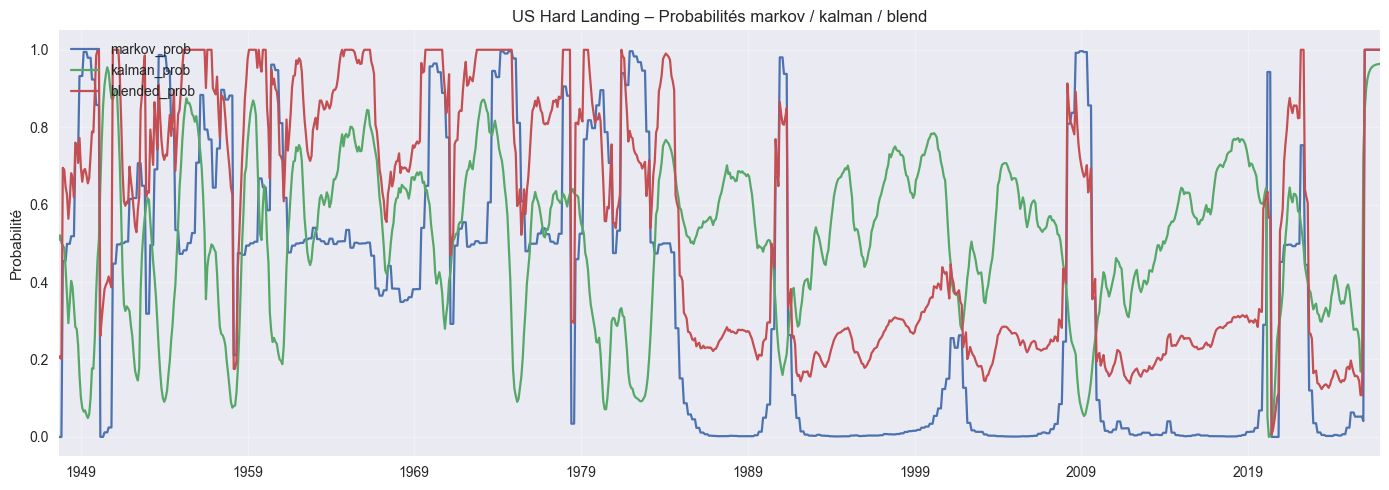

In [6]:
regime_cols = [
    "recession_prob",
    "reprise_prob",
    "boom_prob",
    "ralentissement_prob",
]
prob_cols = ["markov_prob", "kalman_prob", "blended_prob"]

fig, ax = plt.subplots(figsize=(14, 5))
scenario_df[prob_cols].plot(ax=ax, lw=1.6)
ax.set(
    title=f"{scenario_label} – Probabilités markov / kalman / blend",
    ylabel="Probabilité",
)
ax.grid(alpha=0.3)
ax.legend(loc="upper left")
plt.tight_layout()


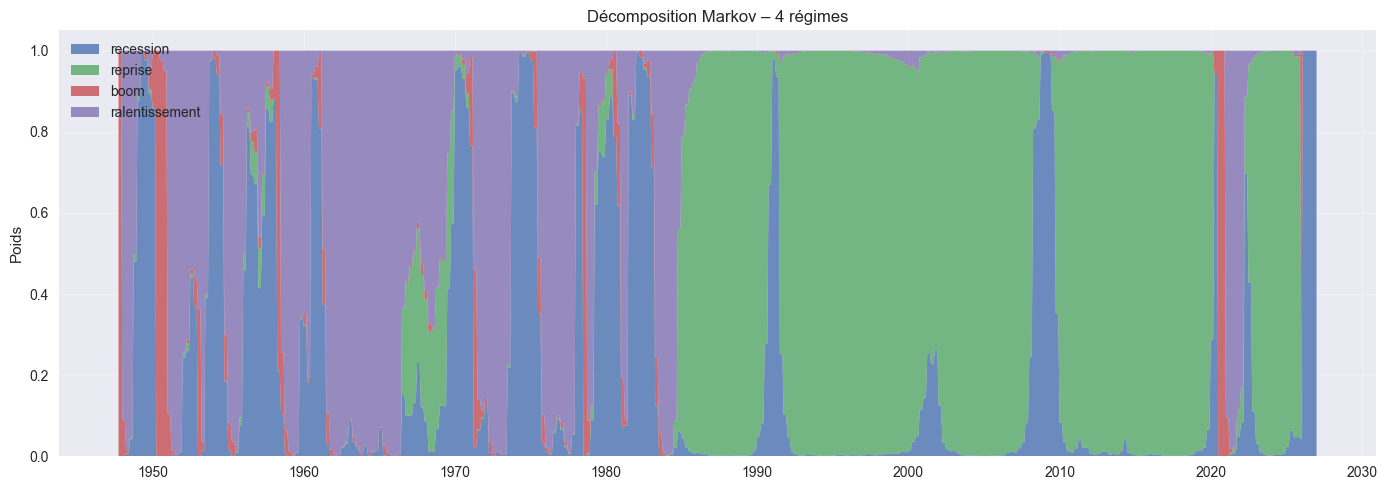

In [7]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.stackplot(
    scenario_df.index,
    *(scenario_df[col].values for col in regime_cols),
    labels=[col.replace("_prob", "") for col in regime_cols],
    alpha=0.8,
)
ax.set(
    title="Décomposition Markov – 4 régimes",
    ylabel="Poids",
)
ax.legend(loc="upper left")
ax.grid(alpha=0.3)
plt.tight_layout()



In [13]:
phase_series = scenario_df["cycle_phase"].copy()
hist_aligned = baseline_df["cycle_phase"].reindex(phase_series.index)
phase_series.loc[phase_series.index <= cutoff] = hist_aligned.loc[
    phase_series.index <= cutoff
]
phase_series = phase_series.dropna().astype(str).str.replace("_prob", "", regex=False)
phase_series = phase_series.reindex(scenario_df.index).ffill()

phase_order = ["recession", "reprise", "boom", "ralentissement"]
phase_cat = pd.Categorical(phase_series, categories=phase_order, ordered=True)
phase_numeric = pd.Series(phase_cat.codes, index=phase_series.index)
phase_codes = {name: idx for idx, name in enumerate(phase_order)}

comparison_index = scenario_df.index.union(baseline_df.index)
comparison = pd.DataFrame(index=comparison_index)
comparison["baseline"] = (
    baseline_df["blended_prob"].reindex(comparison_index).ffill()
)
comparison[scenario_label] = (
    scenario_df["blended_prob"].reindex(comparison_index).ffill()
)

recent_start = pd.Timestamp("2020-01-01")
phase_subset = phase_numeric.loc[recent_start:]
comp_subset = comparison.loc[recent_start:]
future_end = scenario_df.index.max()


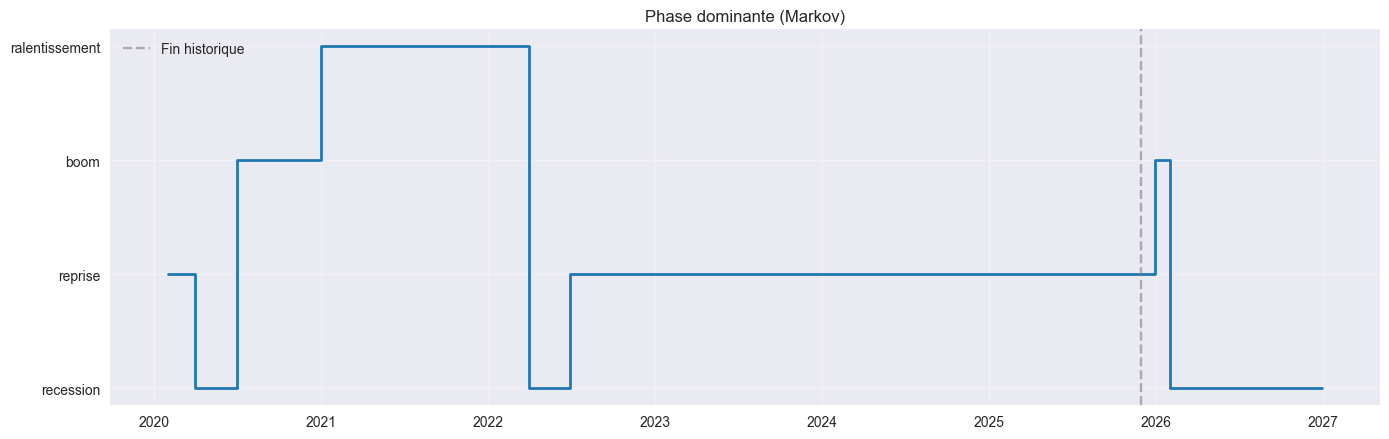

In [14]:
fig, ax = plt.subplots(figsize=(14, 4.5))
ax.step(phase_subset.index, phase_subset, where="post", lw=2, color="#1f77b4")
ax.axvline(cutoff, color="grey", linestyle="--", alpha=0.6, label="Fin historique")
ax.set(
    title="Phase dominante (Markov)",
    yticks=list(phase_codes.values()),
    yticklabels=phase_order,
)
ax.legend(loc="upper left")
ax.grid(alpha=0.3)
plt.tight_layout()



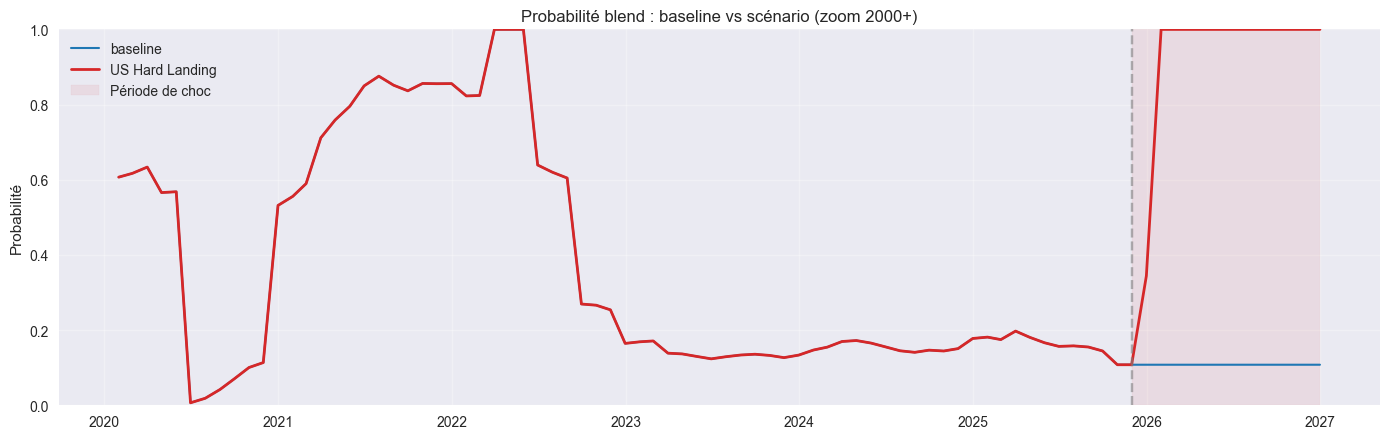

In [15]:
fig, ax = plt.subplots(figsize=(14, 4.5))
ax.plot(comp_subset.index, comp_subset["baseline"], label="baseline", lw=1.5, color="#1f77b4")
ax.plot(comp_subset.index, comp_subset[scenario_label], label=scenario_label, lw=2, color="#d62728")
ax.axvline(cutoff, color="grey", linestyle="--", alpha=0.6)
ax.axvspan(cutoff, future_end, color="#d62728", alpha=0.08, label="Période de choc")
ax.set(title="Probabilité blend : baseline vs scénario (zoom 2000+)", ylabel="Probabilité")
ax.set_ylim(0, 1)
ax.legend(loc="upper left")
ax.grid(alpha=0.3)
plt.tight_layout()

